## Martin Dionne

# 1. Regressive Tennis T-Test

Use a linear regression and statsmodels to run a t-test on whether Federer scores more points than his opponents in the `tennis.csv` dataset.

Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value. 

Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [75]:
df = pd.read_csv('data/tennis.csv')
sub = df[['player1 total points won','player2 total points won']]
sub = sub.dropna()

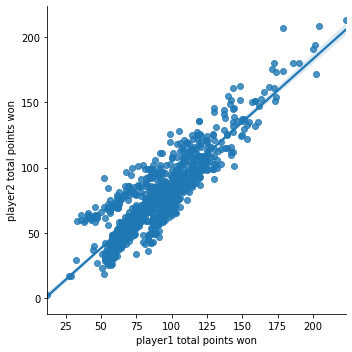

In [76]:
#sns.lmplot(y='player2 total points won', x='player1 total points won', data=df, hue='win', order=1)
sns.lmplot(y='player2 total points won', x='player1 total points won', data=df, order=1)

In [77]:
y = sub['player2 total points won']
x = sub['player1 total points won']
est = sm.OLS(y, x).fit(cov_type='HC2')
est.summary()

# p value < 0.05 so when Federer score 1 point player2 score 0.86 point (less points)
# F-stat indicate a significant result
# addind a constant term reduce R-squared significantly

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     player2 total points won   R-squared (uncentered):                   0.969
Model:                                  OLS   Adj. R-squared (uncentered):              0.969
Method:                       Least Squares   F-statistic:                          2.963e+04
Date:                      Sat, 16 Jan 2021   Prob (F-statistic):                        0.00
Time:                              20:08:08   Log-Likelihood:                         -4173.8
No. Observations:                      1027   AIC:                                      8350.
Df Residuals:                          1026   BIC:                                      8355.
Df Model:                                 1                                                  
Covariance Type:                        HC2                                                  
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
player1 total points won     0.8618      0.005    172.127      0.000       0.852       0.872
==============================================================================
Omnibus:                       70.330   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.878
Skew:                           0.698   Prob(JB):                     6.11e-19
Kurtosis:                       3.093   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

# 2. College admissions

Using the `college.csv` dataset, answer the following:

1. Is the relation between `Top10perc` and `Top25perc` best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for `Private`. Explain your model specification choices.


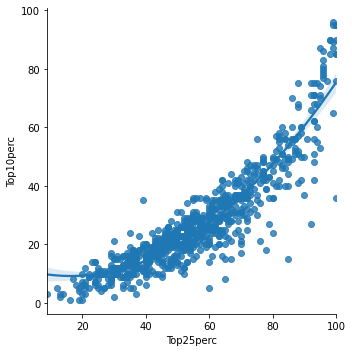

In [84]:
# 1. Is the relation between Top10perc and Top25perc best fit
df = pd.read_csv('data/college.csv')

#plt.scatter(df.Top25perc, df.Top10perc)
sns.lmplot(x="Top25perc", y="Top10perc", data=df, order=2)

# logicaly the intersect should be 0,0 (no need for a constant term)
# a polynomial of degree 2 will fit the data better

In [82]:
# 2. Do private schools see more admissions overall?
x = df.Private.replace('Yes', 1).replace('No', 0)
y = df.Accept
#df.Private.unique()
est = sm.OLS(y, x).fit(cov_type='HC2')
est.summary()
# yes, Private schools see 1305 (+- 57) more Acceptance

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Accept   R-squared (uncentered):                   0.123
Model:                            OLS   Adj. R-squared (uncentered):              0.122
Method:                 Least Squares   F-statistic:                              513.5
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                    1.18e-87
Time:                        20:11:22   Log-Likelihood:                         -7316.3
No. Observations:                 777   AIC:                                  1.463e+04
Df Residuals:                     776   BIC:                                  1.464e+04
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Private     1305.7027     57.617     22.662      0.000    1192.775    1418.631
==============================================================================
Omnibus:                      523.900   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7137.076
Skew:                           2.899   Prob(JB):                         0.00
Kurtosis:                      16.669   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [86]:
#sns.lmplot(x="Private", y="Accept", data=df, order=1)

# 3. Auto prediction

Using the `auto.csv` dataset, perform a simple linear regression with `mpg` as the response variable and horsepower as the predictor. Answer the following:

 i. Is there a relationship between the predictor and the response?
 
 ii. How strong is the relationship between the predictor and the response?
 
 iii. Is the relationship between the predictor and the response positive or negative?

 iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?

 v. Make a regression plot the response and the predictor.

In [88]:
names = ['mpg','cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
df = pd.read_csv('data/auto.csv', skiprows=[0,1], delim_whitespace=True, names = names)
df.horsepower = df.horsepower.replace('?', np.nan).astype('float')

In [89]:
sub = df[['mpg','horsepower']].dropna()
sub['horsepower_2'] = sub.horsepower ** 2

y = sub.mpg
x = sub.drop(columns=['mpg'])

#est = sm.OLS(y, sm.add_constant(x)).fit(cov_type='HC2')
est = sm.OLS(y, x).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.889
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              1923.
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                   1.02e-202
Time:                        20:12:56   Log-Likelihood:                         -1382.5
No. Observations:                 392   AIC:                                      2769.
Df Residuals:                     390   BIC:                                      2777.
Df Model:                           2                                                  
Covariance Type:                  HC2                                                  
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
horsepower       0.4980      0.016     30.448      0.000       0.466       0.530
horsepower_2    -0.0024      0.000    -18.010      0.000      -0.003      -0.002
==============================================================================
Omnibus:                       34.442   Durbin-Watson:                   0.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.889
Skew:                           0.801   Prob(JB):                     8.02e-10
Kurtosis:                       3.028   Cond. No.                         440.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [91]:
# i. Is there a relationship between the predictor and the response?
# yes p value << 0.05
 
# ii. How strong is the relationship between the predictor and the response?
# R-squared = 0.889, p F-stat << 0.05, so quite strong

# iii. Is the relationship between the predictor and the response positive or negative?
# negative because as the horsepower grow the mpg drop

In [49]:
# iv. What is the predicted mpg associated with a horsepower of 98? 
# What are the associated 95 % confidence and prediction intervals ?

res = est.get_prediction([98, 98**2])
print(f'{round(est.predict([98, 98*98])[0],2)} mpg with conf int of [{round(res.conf_int()[0][0],3)}, {round(res.conf_int()[0][1],3)}]')

25.99 mpg with conf int of [25.093, 26.887]


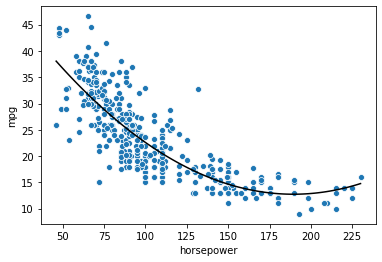

In [60]:
# v. Make a regression plot the response and the predictor.
#sns.lmplot(x="horsepower", y="mpg", data=df, order=2)

fmin, fmax = sub.horsepower.min(), sub.horsepower.max()
coefs = np.polyfit(sub.horsepower, sub.mpg, 2)
#print(coefs)
sns.scatterplot(sub.horsepower, sub.mpg)
xfit = np.linspace(fmin, fmax, 100)
yfit = np.polyval(coefs, xfit)
sns.lineplot(xfit, yfit, color="black")

# 4. Auto Multiple Regression

Perform a multiple linear regression with `mpg` as the response and all other variables except name in `auto` as the predictors. Comment on the output:

i. Is there a relationship between the predictors and the response?

ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

v. Is there heteroscedasticity in the fit?

In [194]:
sub = df.dropna()
y = sub.mpg
x = sub.drop(columns=['mpg', 'name'])

est = sm.OLS(y, x).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              2829.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                        0.00
Time:                        20:53:46   Log-Likelihood:                         -1030.4
No. Observations:                 392   AIC:                                      2075.
Df Residuals:                     385   BIC:                                      2103.
Df Model:                           7                                                  
Covariance Type:                  HC2                                                  
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.7055      0.295     -2.395      0.017      -1.283      -0.128
displacement     0.0219      0.008      2.598      0.009       0.005       0.038
horsepower      -0.0396      0.013     -2.992      0.003      -0.065      -0.014
weight          -0.0060      0.001     -8.301      0.000      -0.007      -0.005
acceleration    -0.0796      0.115     -0.695      0.487      -0.304       0.145
year             0.5836      0.026     22.193      0.000       0.532       0.635
origin           1.3100      0.275      4.759      0.000       0.770       1.849
==============================================================================
Omnibus:                       46.837   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.015
Skew:                           0.681   Prob(JB):                     2.84e-20
Kurtosis:                       4.912   Cond. No.                     6.00e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large,  6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [197]:
#sns.lmplot(x="displacement", y="mpg", data=df, order=2)
#sns.lmplot(x="weight", y="mpg", data=df, order=2)
#sns.lmplot(x="year", y="mpg", data=df, order=1)

In [ ]:
#https://www.statsmodels.org/stable/diagnostic.html

# i. Is there a relationship between the predictors and the response?
    # yes, R-squared = 0.982 

# ii. Which predictors appear to have a statistically significant relationship to the response?
    # all, except for acceleration (p value > 0.05)

# iii. What does the coefficient for the year variable suggest?
    # each year there's a gain in mpg by 0.5836

# iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?
    # Durbin-Watson value is not that close to 2 suggesting some autocorrelation in residuals 
    # probably between cylinders, displacement and horsepower

# v. Is there heteroscedasticity in the fit?
    # yes because mpg measurement can change over time
    # but I used a Robust Standard Errors (HC2) to handle that

In [193]:
# better model
sub = df.dropna()
y = sub.mpg
# cylinders and displacement are correlated with horsepower (best predictor)
x = sub.drop(columns=['mpg', 'name', 'acceleration', 'cylinders', 'displacement'])

#x['displacement_2'] = sub.displacement ** 2
x['horsepower_2'] = sub.horsepower ** 2
x['weight_2'] = sub.weight ** 2
#x['origin_2'] = sub.origin ** 2

est = sm.OLS(y, x).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              4676.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                        0.00
Time:                        20:52:05   Log-Likelihood:                         -972.31
No. Observations:                 392   AIC:                                      1957.
Df Residuals:                     386   BIC:                                      1980.
Df Model:                           6                                                  
Covariance Type:                  HC2                                                  
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
horsepower      -0.1577      0.041     -3.868      0.000      -0.238      -0.078
weight          -0.0144      0.002     -7.977      0.000      -0.018      -0.011
year             0.8017      0.027     29.823      0.000       0.749       0.854
origin           0.7085      0.232      3.059      0.002       0.255       1.162
horsepower_2     0.0005      0.000      3.876      0.000       0.000       0.001
weight_2      1.501e-06   2.36e-07      6.346      0.000    1.04e-06    1.96e-06
==============================================================================
Omnibus:                       37.862   Durbin-Watson:                   1.481
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.458
Skew:                           0.583   Prob(JB):                     1.36e-15
Kurtosis:                       4.682   Cond. No.                     1.72e+07
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 5. Car Seats

This question should be answered using the Carseats data set

1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

In [226]:
df = pd.read_csv('data/carseats.csv')
df = df.join(pd.get_dummies(df.ShelveLoc, drop_first=True, prefix='ShelveLoc'))
df.Urban = df.Urban.replace('Yes', 1).replace('No', 0)
df.US = df.US.replace('Yes', 1).replace('No', 0)
df = df.drop(columns=['ShelveLoc'])
df

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_Good,ShelveLoc_Medium
0,9.50,138,73,11,276,120,42,17,1,1,0,0
1,11.22,111,48,16,260,83,65,10,1,1,1,0
2,10.06,113,35,10,269,80,59,12,1,1,0,1
3,7.40,117,100,4,466,97,55,14,1,1,0,1
4,4.15,141,64,3,340,128,38,13,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,33,14,1,1,1,0
396,6.14,139,23,3,37,120,55,11,0,1,0,1
397,7.41,162,26,12,368,159,40,18,1,1,0,1
398,5.94,100,79,7,284,95,50,12,1,1,0,0


In [222]:
# 1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

y = df.Sales
x = df[['Price','Urban','US']]

est = sm.OLS(y, x).fit(cov_type='HC2')
#est = sm.OLS(y, sm.add_constant(x)).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.809
Method:                 Least Squares   F-statistic:                              599.3
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                   5.66e-147
Time:                        21:35:11   Log-Likelihood:                         -1067.7
No. Observations:                 400   AIC:                                      2141.
Df Residuals:                     397   BIC:                                      2153.
Df Model:                           3                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Price          0.0406      0.003     13.236      0.000       0.035       0.047
Urban          1.2917      0.384      3.365      0.001       0.539       2.044
US             2.1948      0.342      6.410      0.000       1.524       2.866
==============================================================================
Omnibus:                        1.426   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                1.214
Skew:                           0.121   Prob(JB):                        0.545
Kurtosis:                       3.120   Cond. No.                         260.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [ ]:
# 2. Provide an interpretation of each coefficient in the model.

    # Price: each time the Price rise by 1 the sales goes up by 0.0406
    # Urban stores get 1.2917 more in sales
    # Stores in US get 2.1948 more in sales

# 3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?
    # none, p value < 0.5

In [231]:
# 4. Fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.
y = df.Sales
#x = df.drop(columns=['Sales', 'Urban', 'US'])
#x = df[['CompPrice','Income','Advertising','Price','Age']]
#x = df[['ShelveLoc_Good','ShelveLoc_Medium']]
x = df[['CompPrice','Advertising']]

est = sm.OLS(y, x).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              1495.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                   7.96e-186
Time:                        21:45:34   Log-Likelihood:                         -976.23
No. Observations:                 400   AIC:                                      1956.
Df Residuals:                     398   BIC:                                      1964.
Df Model:                           2                                                  
Covariance Type:                  HC2                                                  
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
CompPrice       0.0526      0.002     34.480      0.000       0.050       0.056
Advertising     0.1285      0.020      6.347      0.000       0.089       0.168
==============================================================================
Omnibus:                        5.693   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.474
Skew:                           0.258   Prob(JB):                       0.0648
Kurtosis:                       3.251   Cond. No.                         18.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [ ]:
# 5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.
    # R-squared is better in 4 also F-stat and log likelyhood are higher

# 6. Using the model from (5), obtain 95 % confidence intervals for the coefficient(s).
    #                coef	std err	    z	P>|z|	[0.025	0.975]
    # CompPrice	    0.0526	0.002	34.480	0.000	0.050	0.056
    # Advertising	0.1285	0.020	6.347	0.000	0.089	0.168
